In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

%matplotlib inline

font_options = {'family' : 'monospace'}
figure_options = {'figsize':[8,5]}

plt.rc('font', **font_options) 
plt.rc('figure', **figure_options)

In [49]:
class GradientDescent:
    """
    Class : GradientDescent

    ....................^_^.....................

    Attributes
    ----------
    points : int, default = 1000
        amount of points for generator
        
    polynomial degree: int, default = 3
        degree of polynom
        
    start_params : np.array, default None, size = degree + 1
        start point for GD
        
    num_iter : int, default = 10000
        steps in GD
        
    lr: float, default = 0.1
        learning rate in GD
        
    batch: int, default = 100
        batch_size in SGD with MB
        
    """
    def __init__(self, points: int = 1000, polynomial_degree: int = 3, \
                 start_params: np.array = None, num_iter: int = 10000, lr = 0.1,batch_size_SGDMB: int = 100):
        
        self.points = points
        self.degree = polynomial_degree
        
        if start_params == None:
            self.params = np.zeros(self.degree+1)
        else:
            self.params = start_params
            
        self.iterations = num_iter
        self.learning_rate = lr
        self.batch = batch_size_SGDMB
        
        self.x = None
        self.y = None
        self._XT = None
        self.true = None
        self.a = []
        self.metric_mse = 0
        
        self.function = {'GD': self.grad_descent, 
                         'SGD':self.stochastic_gradient_descent,
                         'SGD-MB': self.stochastic_mini_batch_gradient_descent}
        
    def batch_generator(self, X, y, batch_size=1):
        '''
        returns random batch
        '''
        perm = np.random.permutation(len(X))
        idxs = perm[:batch_size]
        return X[idxs], y[idxs]

    def generate_points(self) -> (np.array,np.array): 
        '''
        generate points
        '''
        np.random.seed(42)
        self.x = np.linspace(0, 1, num = self.points)        
        self.y = np.cos(1.5*np.pi*self.x) + np.random.normal(0, 1, size = self.points)*0.02
        return self.x, self.y

    def preprocess(self):
        self.generate_points()
        self.a.clear()
        poly = PolynomialFeatures(self.degree)
        self._XT = poly.fit_transform(self.x.reshape(-1,1))

    def grad(self, f, x, eps = 2**(-24)) -> np.array:
        '''
        return gradient of function
        '''
        value = np.array([f(x + dx) - f(x) for dx in eps * np.eye(x.shape[0])])
        return value / eps
    
    def mse(self, X, y): 
        '''
        return functional of quality
        '''
        MSE = lambda p: np.mean((y - X@p)**2)
        return MSE
    
    def grad_descent(self):
        '''
        return fitted params and polyfeatures matrix _XT
        '''
        self.preprocess()
        for _ in range(self.iterations):
            self.params -= self.grad(f = self.mse(self._XT, self.y), x = self.params)*self.learning_rate
            self.a.append(np.mean((self._XT @ self.params - self.y)**2))
        return self.params, self._XT
    
    def stochastic_gradient_descent(self):
        '''
        stochatisc gradient descent with batch_size = 1
        '''
        self.preprocess()
        for _ in range(self.iterations):
            x_batch, y_batch = self.batch_generator(X=self._XT, y=self.y, batch_size = 1)

            self.params -= self.grad(f = self.mse(x_batch, y_batch), x = self.params)*self.learning_rate
            
            self.a.append(np.mean((self._XT @ self.params - self.y)**2))
        return self.params, self._XT
    
    
    def stochastic_mini_batch_gradient_descent(self):      
        '''
        SGD with Mini Batches: Default = 100
        '''
        self.preprocess()
        for _ in range(self.iterations):
            x_batch, y_batch = self.batch_generator(X=self._XT, y=self.y, batch_size = self.batch) #generate batch
    
            self.params -= self.grad(f = self.mse(x_batch, y_batch), x = self.params)*self.learning_rate
        
            self.a.append(np.mean((self._XT @ self.params - self.y)**2)) #mse metric changes
    
        return self.params, self._XT
        
    def visual(self,method: str = 'GD'):
        '''
        visualisation of GD, returns pyplot
        '''
        fun = self.function[method]
        fun()
        
        prediction = self._XT @ self.params
        
        self.true = self._XT @ np.linalg.inv( self._XT.T@self._XT ) @ self._XT.T @self.y 
        
        fig, ax = plt.subplots(figsize = (16,10),sharex=True,sharey=True,frameon = False)
        
        ax.plot(self.x, prediction,\
                label = f'Polynomial Regression: Degree {self.degree}, Method: {method}', color = 'blue')
        
        ax.scatter(self.x, self.y, s = 1, label = r'$y = 1.5\cos(1.5 \pi x)$', color = 'black')
        
        ax.plot(self.x, self.true, label = f'Best Fitted', color = 'red')
        
        dict_methods = {'GD':'Gradient Descent', 'SGD': 'Stochastic Gradient Descent',\
                        'SGD-MB': 'Stochastic Gradient Descent With Mini-Batches'}
        self.metric_mse = np.mean((prediction-self.y)**2)
        ax.set_title(f'Polynomial Regression {dict_methods[method]}: MSE {self.metric_mse}')
        
        plt.legend()
        plt.grid()
        plt.show()
        print(self.metric_mse)
    
    
    def visual_mse(self):
        '''
        visualisation of MSE metric
        '''
        iterate = np.arange(0,self.iterations)
        fig, ax = plt.subplots(figsize = (16,10),sharex=True,sharey=True,frameon = False)
        ax.scatter(iterate, self.a ,label = f'MSE: iterations', color = 'black',s=1)
        ax.set_title("Changes of MSE")
        plt.legend()
        plt.grid()
        plt.show()

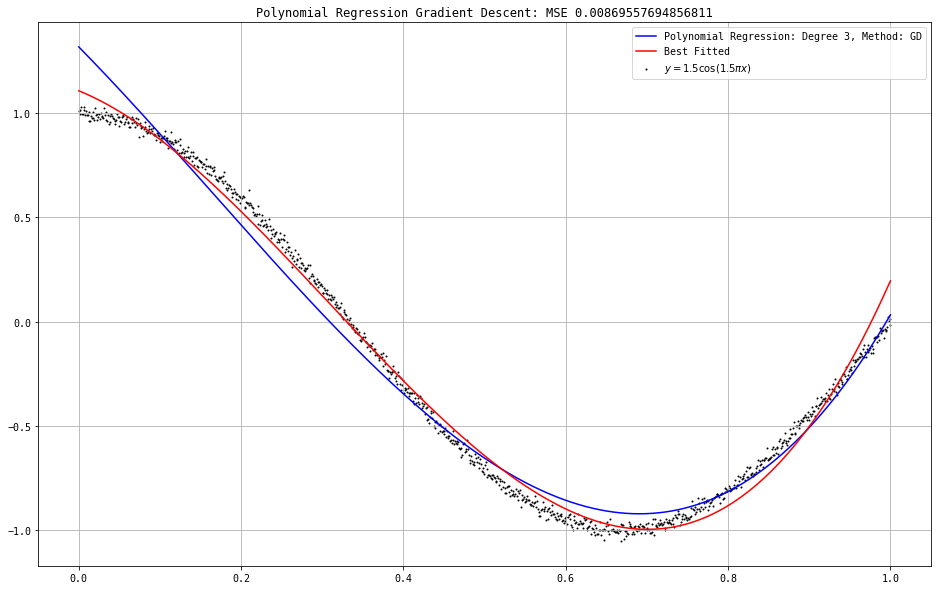

0.00869557694856811


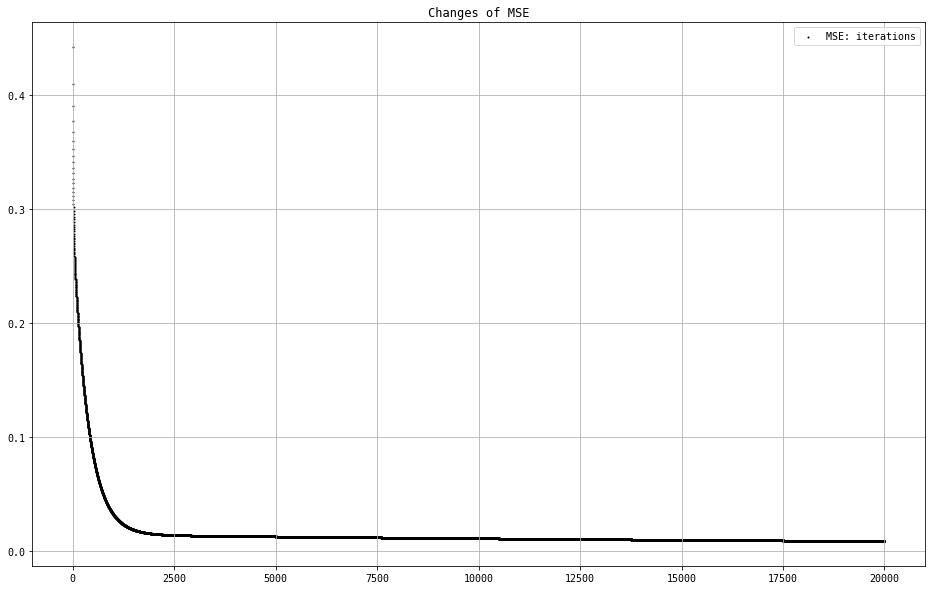

In [53]:
GD = GradientDescent(polynomial_degree=3,num_iter = 20000,lr=0.1,batch_size_SGDMB=100)
GD.visual(method='GD')
GD.visual_mse()

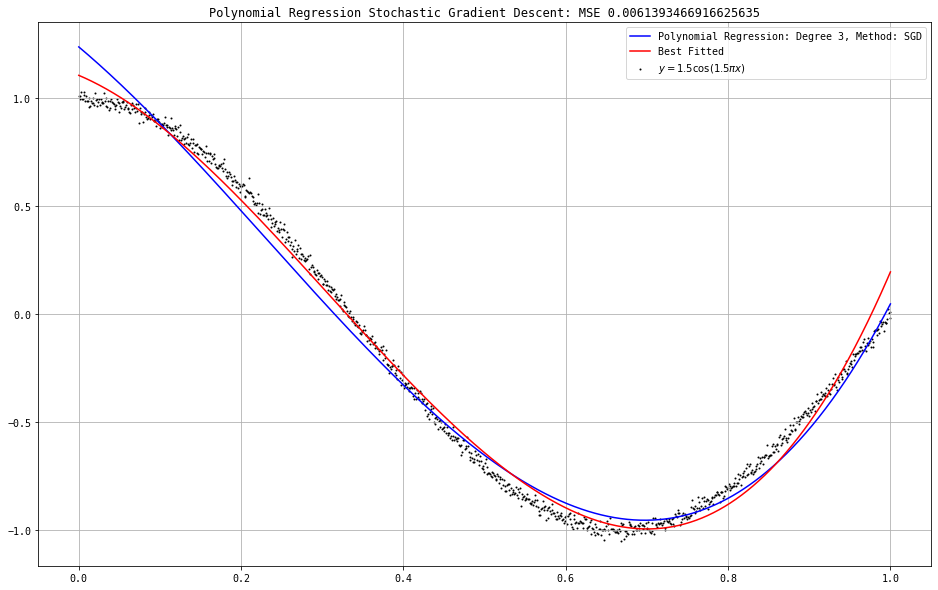

0.0061393466916625635


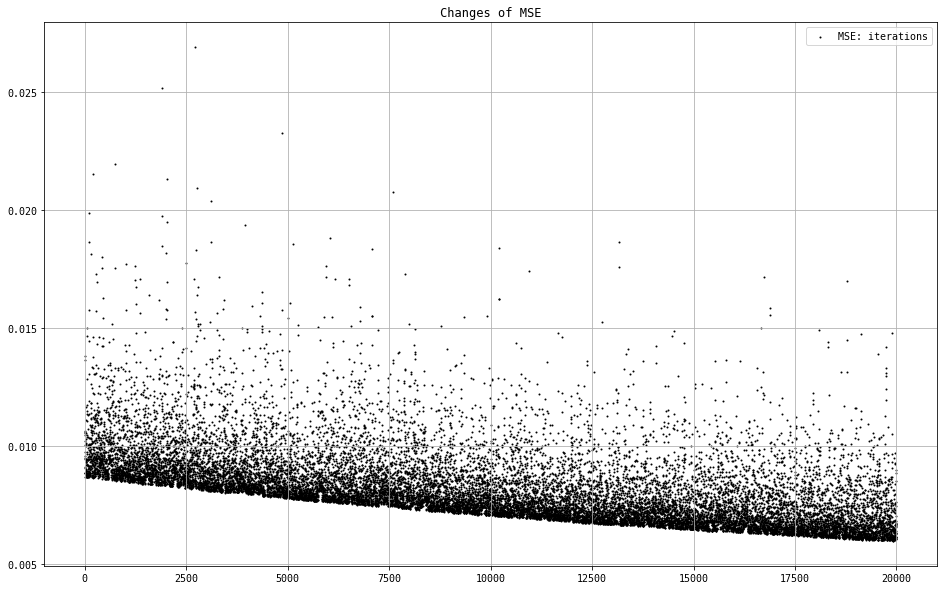

In [54]:
GD.visual(method='SGD')
GD.visual_mse()

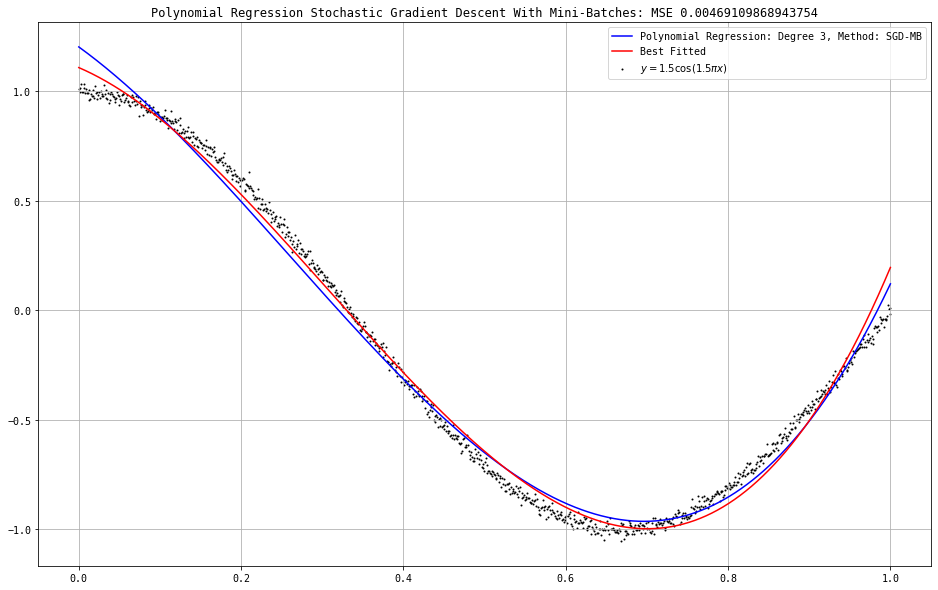

0.00469109868943754


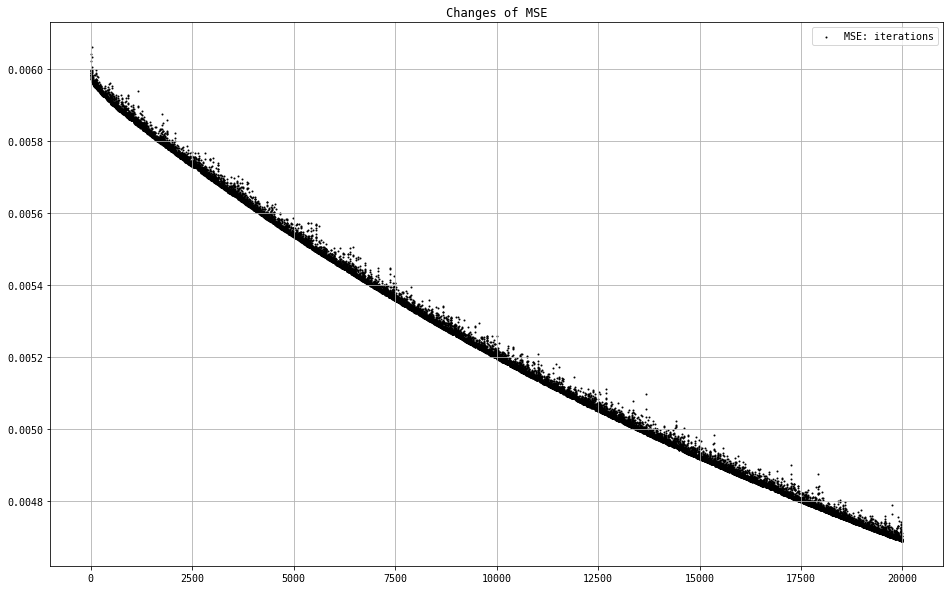

In [55]:
GD.visual(method='SGD-MB')
GD.visual_mse()